# MIMIC2 Radiology Impression Section Extractor

Identify impression section and extract

In [46]:
%matplotlib inline

In [45]:
import sqlite3 as sq
import re
from textblob import TextBlob
import zipfile
import gzip
import os
import numpy as np
from IPython.display import clear_output
import pickle
import seaborn as sns

In [6]:
DATADIR = os.path.join(os.path.expanduser("~"),"Bdrive","Radiology","NLP","DBs")
print(os.path.exists(DATADIR))

True


In [2]:
conn = sq.connect("./mimic_radreports.sqlite")
cursor = conn.cursor()

### Grab the text from the database

In [16]:
cursor.execute("""SELECT text FROM reports""")
reports = [r[0].strip() for r in cursor.fetchall()]

### A simple regex to identify numbers

In [2]:

rdigit = re.compile(r"""\d""")


## Define code to extract impression section

I provide some "synonyms" to impression and try splitting report with the prioritized list. To get a sense of the relative importance, I also return what phrase I finally split on.

In [4]:
splits = ["IMPRESSION:", "INTERPRETATION:", "CONCLUSIONS:", "FINDINGS:"]


def get_split_location(report, splits=None):
    if splits == None:
        splits = ["IMPRESSION:", "INTERPRETATION:", "CONCLUSIONS:", "FINDINGS:"]
    for s in splits:
        try:
            return report.index(s),s
        except:
            pass
    return -1,"NA"


def get_impressions(reports, splits=None):
    impression_loc = [get_split_location(r,splits=splits) for r in reports]
    return[(d[0][d[1][0]:],d[1]) for d in zip(reports, impression_loc) if d[1][0] != -1]


def get_reports(fname="pah_mimic2.sqlite", query="""SELECT text FROM mimic_pah_radiology"""):
    """My Docstring"""
    conn = sq.connect(os.path.join(DATADIR,fname))
    cursor = conn.cursor()
    cursor.execute(query)
    return [r[0] for r in cursor.fetchall()]

In [7]:
pah_impressions = get_impressions(get_reports(), splits=splits)
copd_impressions =get_impressions(get_reports(query="""SELECT text FROM mimic_copd_radiology"""), splits=splits)
print(len(pah_impressions))
print(len(copd_impressions))



2914
15128


### What does an impression look like?

In [8]:
pah_impressions[0]

('IMPRESSION:\n     \n     1.  Evaluation limited by lack of IV contrast; however, no evidence of\n      bowel obstruction or mass identified within the abdomen or pelvis.\n     \n     2.  Non-specific interstitial opacities and bronchiectasis seen at the right\n     base, suggestive of post-inflammatory changes\n\n',
 (3688, 'IMPRESSION:'))

### Get ride of our split phrase

In [9]:
ipah = [p[0].split(p[1][1])[1] for p in pah_impressions]
icopd = [p[0].split(p[1][1])[1] for p in copd_impressions]

In [10]:
ipah2 = [ [[w for w in s.words] for s in TextBlob(rdigit.sub("""d""", r.strip().lower())).sentences] for r in ipah]
icopd2 = [ [[w for w in s.words] for s in TextBlob(rdigit.sub("""d""", r.strip().lower())).sentences] for r in icopd]

### Read in Radiology phrase generators

In [14]:
with gzip.open(os.path.join(DATADIR,"mimic2_demo_n_gram_generators.pickle.gz"),"rb") as f0:
    ngp = pickle.load(f0)

In [16]:
pah_phrases = [ngp["3-gram"][ngp["2-gram"][s]] for s in ipah2]
copd_phrases = [ngp["3-gram"][ngp["2-gram"][s]] for s in icopd2]

In [35]:
def get_impression_words_from_phrases(sp):
    return [ss for s in sp for ss in s]

In [36]:
def view_impression_phrases(sp):
    return " ".join(get_impression_words_from_phrases(sp))

In [37]:
view_impression_phrases(pah_phrases[135])

'there is a new right ij line with tip in the right atrium there is no pneumothorax there has_been no significant interval change in the linear_atelectasis on the right with a right pleural_effusion'

In [38]:
pah_impression_phrases = [get_impression_words_from_phrases(sp) for sp in pah_phrases]
copd_impression_phrases = [get_impression_words_from_phrases(sp) for sp in copd_phrases]

### How long is our longest impression section

In [41]:
pah_lengths = [len(i) for i in pah_impression_phrases]
copd_lengths = [len(i) for i in copd_impression_phrases]

In [44]:
pah_sizes = (np.mean(pah_lengths),np.max(pah_lengths),np.min(pah_lengths))
copd_sizes = (np.mean(copd_lengths),np.max(copd_lengths),np.min(copd_lengths))
print(pah_sizes,copd_sizes)

(38.504461221688402, 752, 1) (38.861316763617133, 1102, 1)


In [49]:
pah_sizes[0:50]

(38.504461221688402, 752, 1)

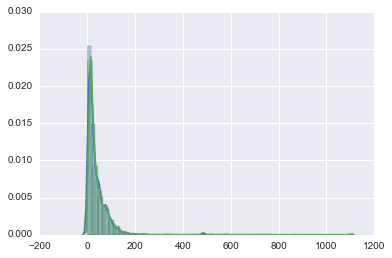

In [51]:
sns.distplot(pah_lengths)
sns.distplot(copd_lengths)

In [21]:
while True:
    #clear_output()
    i = int(input("Enter sentence #\n"))
    print(" ".join(pah_phrases[i]))

Enter sentence #
111


TypeError: sequence item 0: expected str instance, list found

In [42]:

for i in impressions:
    try:
        clear_output()
        print(i[0])
        print(i[1])
        input('continue')
    except:
        break

FINDINGS:  On diffusion-weighted images there is a small area of restricted
     diffusion along the falx within the left occipitotemporal lobe.  It is also
     bright on FLAIR-weighted images and may represent a subacute infarct. Clinical
     correlation is recommended.  On gradient echo images there is a large area of
     intraparenchymal hemorrhage within the right parietal lobe and left thalamus
     which following administration of gadolinium reveals ring-enhancing lesions.
     These are suspicious for hemorrhagic metastases given the patient's history.
     Additional ring-enhancing lesions throughout the supra- and infratentorial
     compartments are visualized.  There is a moderate amount of peritumoral edema
     involving the right parietal lobe lesion in addition to a second right
     parietal lesion along the falx high in the vertex.  The other areas of
     metastases reveal a minimal amount of peritumoral edema.
(1179, 'FINDINGS:')


### Define Regular expressions for further cleansing

Here are some regular expression for finding dates and times. I decided to do a simple conversion from digits to the letter ``d`` leaving everything in place.

In [12]:
with gzip.open(os.path.join(os.path.expanduser("~"), 
                            "Bdrive/Radiology/NLP/DBs", 
                            "mimic2_radsentences.txt.gz"), "rt") as f:
    sentences = f.readlines()

In [13]:
sentences[0]

'd,a,t,e,:, ,[,*,*,d,d,d,d,-,d,-,d,d,*,*,], ,d,d,:,d,d, ,a,m,\n'

In [15]:
pah_impressions = get_impressions(pah_reports)
copd_impressions = get_impressions(copd_reports)

WordList(['no', 'pneumothorax'])